In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Ensure src/ is in the Python path
sys.path.append(os.path.abspath("src"))

# Auto-download spaCy model if missing (Portability Requirement)
!{sys.executable} -m spacy download en_core_web_sm

# Import local modules
from src.data_loader import load_sts_train, load_sts_test
from src.features import lexical_features, syntactic_features, combined_features
from src.models import (
    build_feature_matrix, train_val_split,
    make_ridge_model, make_svr_model, make_rf_model,
    fit_and_eval
)

# Load Training Data (MSRpar, MSRvid, SMTeuroparl)
print("Loading Training Data...")
train_df = load_sts_train("./train")
print(train_df["source"].value_counts())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.7 MB/s  0:00:00 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
--- Checking and Downloading Resources ---
Loading Training Data...
source
MSRpar         750
MSRvid         750
SMTeuroparl    734
Name: count, dtype: int64


In [2]:
# --- Feature Engineering & Matrix Construction ---

print("Extracting Features... (This may take 1-2 minutes)")

# 1. Lexical (Baseline)
X_lex, y = build_feature_matrix(train_df, lexical_features)

# 2. Syntactic (TakeLab approach)
X_syn, _ = build_feature_matrix(train_df, syntactic_features)

# 3. Combined Ensemble (UKP + TakeLab approach)
# Includes: Lexical, WordNet, Syntax, Negation, N-grams, Entities, BLEU, LCS, Numbers, Stopwords
X_comb, _ = build_feature_matrix(train_df, combined_features)

# Create Train/Validation splits
X_lex_tr, X_lex_val, y_tr, y_val = train_val_split(X_lex, y)
X_syn_tr, X_syn_val, _, _       = train_val_split(X_syn, y)
X_comb_tr, X_comb_val, _, _     = train_val_split(X_comb, y)

print(f"Combined Feature Matrix Shape: {X_comb.shape}")

Extracting Features... (This may take 1-2 minutes)
Combined Feature Matrix Shape: (2234, 15)


In [3]:
# --- Model Training & Selection ---

print("Training Models & Tuning Hyperparameters...")

results = []

# --- Train & Evaluate on Validation Set ---
# We test 3 algorithms x 3 feature sets to find the best configuration.

# 1. Lexical Only
_, p_ridge_lex = fit_and_eval(make_ridge_model(), X_lex_tr, y_tr, X_lex_val, y_val)
_, p_svr_lex   = fit_and_eval(make_svr_model(),   X_lex_tr, y_tr, X_lex_val, y_val)
_, p_rf_lex    = fit_and_eval(make_rf_model(),    X_lex_tr, y_tr, X_lex_val, y_val)
results.extend([("Ridge-Lex", p_ridge_lex), ("SVR-Lex", p_svr_lex), ("RF-Lex", p_rf_lex)])

# 2. Syntactic Only
_, p_ridge_syn = fit_and_eval(make_ridge_model(), X_syn_tr, y_tr, X_syn_val, y_val)
_, p_svr_syn   = fit_and_eval(make_svr_model(),   X_syn_tr, y_tr, X_syn_val, y_val)
_, p_rf_syn    = fit_and_eval(make_rf_model(),    X_syn_tr, y_tr, X_syn_val, y_val)
results.extend([("Ridge-Syn", p_ridge_syn), ("SVR-Syn", p_svr_syn), ("RF-Syn", p_rf_syn)])

# 3. Combined Ensemble
# This model represents the final configuration
best_ridge, p_ridge_comb = fit_and_eval(make_ridge_model(), X_comb_tr, y_tr, X_comb_val, y_val)
best_svr,   p_svr_comb   = fit_and_eval(make_svr_model(),   X_comb_tr, y_tr, X_comb_val, y_val)
best_rf,    p_rf_comb    = fit_and_eval(make_rf_model(),    X_comb_tr, y_tr, X_comb_val, y_val)
results.extend([("Ridge-Comb", p_ridge_comb), ("SVR-Comb", p_svr_comb), ("RF-Comb", p_rf_comb)])

# Show Validation Leaderboard
pd.DataFrame(results, columns=["Model", "Val_Pearson"]).sort_values("Val_Pearson", ascending=False)

Training Models & Tuning Hyperparameters...
[model] Best Params: {'model__alpha': 1.0}
[model] Best Params: {'model__C': 100.0, 'model__epsilon': 0.2, 'model__gamma': 'scale'}
[model] Best Params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
[model] Best Params: {'model__alpha': 10.0}
[model] Best Params: {'model__C': 1.0, 'model__epsilon': 0.2, 'model__gamma': 'scale'}
[model] Best Params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
[model] Best Params: {'model__alpha': 1.0}
[model] Best Params: {'model__C': 1.0, 'model__epsilon': 0.2, 'model__gamma': 0.1}
[model] Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300}


,Model,Val_Pearson
7,SVR-Comb,0.832124
8,RF-Comb,0.832080
6,Ridge-Comb,0.728750
2,RF-Lex,0.728720
1,SVR-Lex,0.708024
5,RF-Syn,0.699326
4,SVR-Syn,0.675709
0,Ridge-Lex,0.606667
3,Ridge-Syn,0.492885


In [4]:
# --- Final Training & Prediction Generation ---

print("Retraining Best Models on FULL Training Data...")

# Retrain the "Combined" Random Forest on all available training data
# (Random Forest usually handles the mix of features best)
final_model = make_rf_model() 
final_model.fit(X_comb, y)
best_estimator = final_model.best_estimator_

# Load Test Data (All 5 sets, including Surprise ones)
test_df = load_sts_test("test-gold")
print(f"Test Sets Loaded: {test_df['source'].unique()}")

# Build Features for Test Data
X_test_comb = build_feature_matrix(test_df, combined_features, has_score=False)

# Predict
test_df["predicted_score"] = best_estimator.predict(X_test_comb)

# Create output folder
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

# Write Output Files into 'output/' folder
for src in test_df["source"].unique():
    subset = test_df[test_df["source"] == src]
    
    # Construct path: output/STS.output.MSRpar.mySystem.txt
    filename = f"STS.output.{src}.mySystem.txt"
    out_path = os.path.join(output_dir, filename)
    
    subset["predicted_score"].to_csv(out_path, sep="\t", header=False, index=False)
    print(f"Generated: {out_path}")

Retraining Best Models on FULL Training Data...
Test Sets Loaded: ['MSRpar' 'MSRvid' 'SMTeuroparl' 'OnWN' 'SMTnews']
Created directory: output
Generated: output/STS.output.MSRpar.mySystem.txt
Generated: output/STS.output.MSRvid.mySystem.txt
Generated: output/STS.output.SMTeuroparl.mySystem.txt
Generated: output/STS.output.OnWN.mySystem.txt
Generated: output/STS.output.SMTnews.mySystem.txt


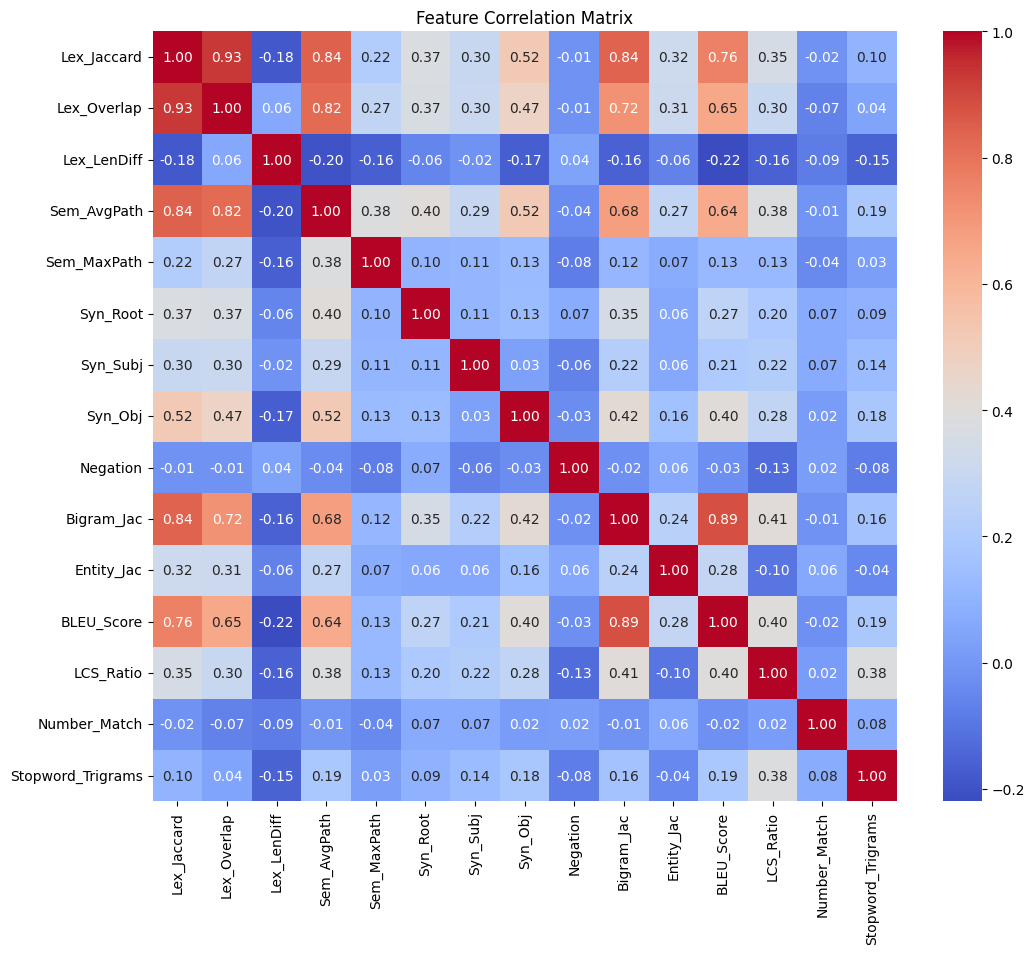

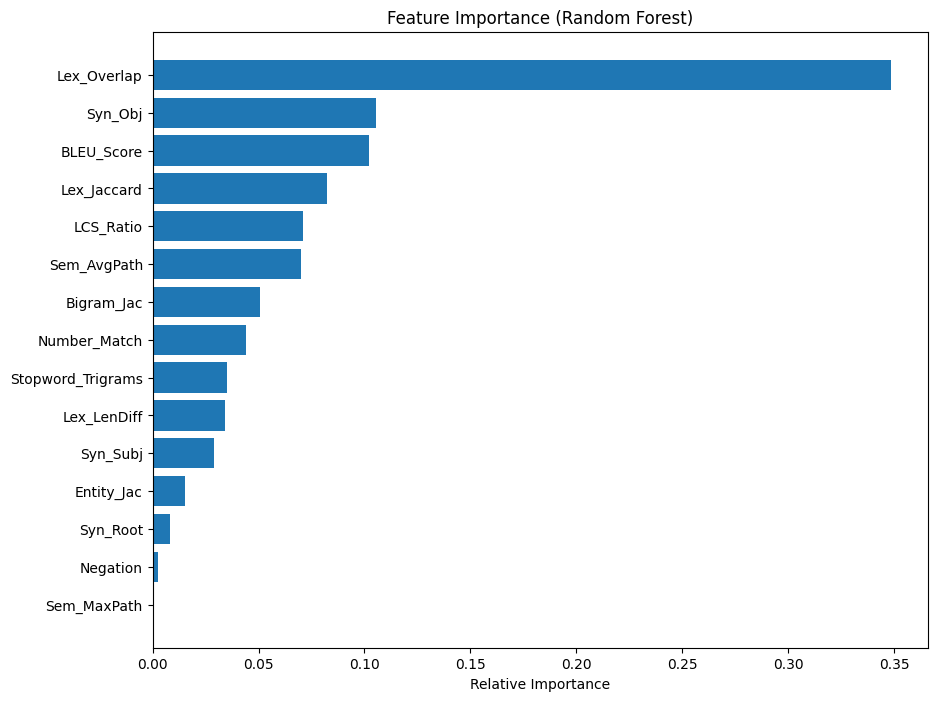

In [5]:
# --- Analysis & Visualization ---

# Feature Names  
feature_names = [
    # Lexical (3)
    "Lex_Jaccard", "Lex_Overlap", "Lex_LenDiff", 
    # Semantic (2)
    "Sem_AvgPath", "Sem_MaxPath",
    # Syntactic (3)
    "Syn_Root", "Syn_Subj", "Syn_Obj",
    # Domain Boosters (6)
    "Negation", "Bigram_Jac", "Entity_Jac",
    "BLEU_Score", "LCS_Ratio", "Number_Match",
    # Stylistic (1)
    "Stopword_Trigrams"
]

# 1. Feature Correlations
# Check if "Syntactic" features provide unique info compared to "Lexical"
df_feats = pd.DataFrame(X_comb_tr, columns=feature_names)
plt.figure(figsize=(12, 10))
sns.heatmap(df_feats.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# 2. Feature Importance
# See which features drove the decision (Expected: Numbers for MSRpar, Lexical for Videos)
if hasattr(best_estimator, "feature_importances_"):
    importances = best_estimator.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importance (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()